<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>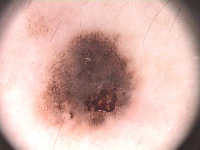</td><td>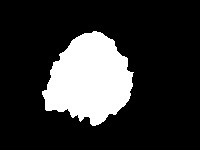</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

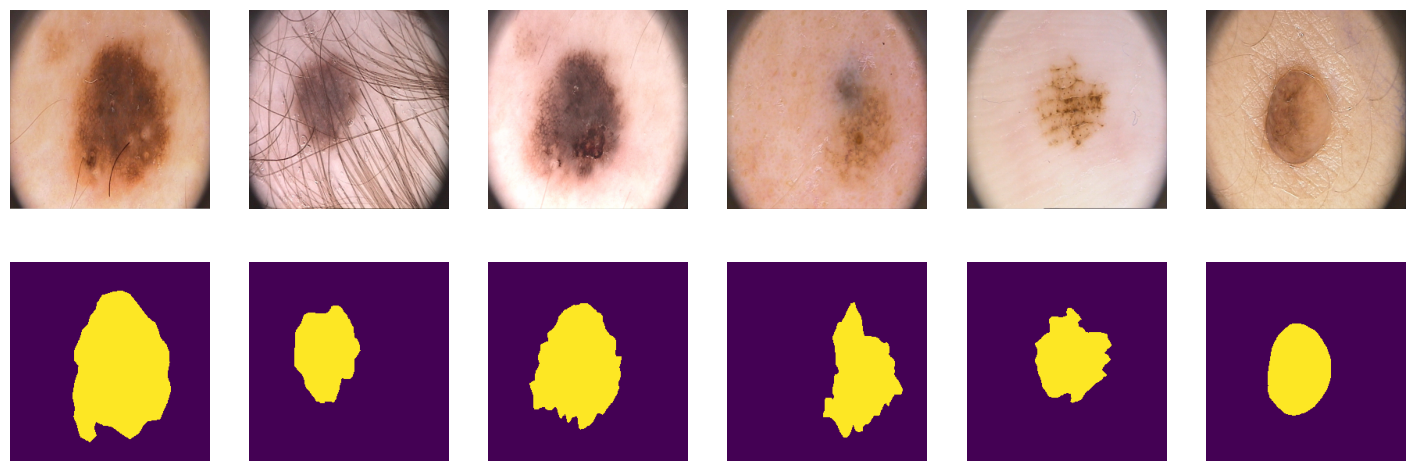

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



<!-- <p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p> -->

<img src="./img/example.png">

In [11]:
# !pip install torchmetrics

In [11]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**


\begin{align*}
& y \cdot \bigl(-\log(\sigma(\hat{y}))\bigr) + (1 - y) \cdot \bigl(-\log(1 - \sigma(\hat{y}))\bigr) \\
=&\; y \cdot \left(-\log\left(\frac{1}{1 + e^{-\hat{y}}}\right)\right) + (1 - y) \cdot \left(-\log\left(\frac{e^{-\hat{y}}}{1 + e^{-\hat{y}}}\right)\right) \\
=&\; y \cdot \log\left(1 + e^{-\hat{y}}\right) + (1 - y) \cdot \left(-\log\left(e^{-\hat{y}}\right) + \log\left(1 + e^{-\hat{y}}\right)\right) \\
=&\; y \cdot \log\left(1 + e^{-\hat{y}}\right) + (1 - y) \cdot \left(\hat{y} + \log\left(1 + e^{-\hat{y}}\right)\right) \\
=&\; (1 - y) \cdot \hat{y} + \log\left(1 + e^{-\hat{y}}\right) \\
=&\; \hat{y} - \hat{y} \cdot y + \log\left(1 + e^{-\hat{y}}\right)
\end{align*}



Такж стоит отметить, что при $\hat{y} < 0$, чтобы избежать переполнения в $exp(-\hat{y})$, переформулируем вышеприведенное:


\begin{align*}
\hat{y} - \hat{y} \cdot y + \log\left(1 + e^{-\hat{y}}\right) 
&= \log\left(e^{\hat{y}}\right) - \hat{y} \cdot y + \log\left(1 + e^{-\hat{y}}\right) \\
&= - \hat{y} \cdot y + \log\left(1 + e^{\hat{y}}\right)
\end{align*}


Следовательно, для обеспечения стабильности и избежания переполнения, реализация использует эту эквивалентную формулировку:

$$ max(\hat{y}, 0) - \hat{y} \cdot y + \log\left(1 + \exp\bigl(-|\hat{y}|\bigr)\right) $$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [12]:
import torch.nn.functional as F
import torch.nn as nn

In [13]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [14]:
def bce_true(y_pred, y_real):
    """
    Вычисляет бинарную кросс-энтропию по формуле:
    max(y_pred, 0) - y_pred * y_real + log(1 + exp(-abs(y_pred)))

    Args:
        y_pred (torch.Tensor): Логиты предсказаний (неприменённая сигмоида).
        y_real (torch.Tensor): Истинные метки (0 или 1), того же размера, что и y_pred.

    Returns:
        torch.Tensor: Значение потерь для каждого элемента.
    """
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum()


def bce_loss(y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
    """
    Вычисляет бинарную кросс-энтропию по формуле:
    max(y_pred, 0) - y_pred * y_real + log(1 + exp(-abs(y_pred)))

    Args:
        y_pred (torch.Tensor): Логиты предсказаний (неприменённая сигмоида).
        y_real (torch.Tensor): Истинные метки (0 или 1), того же размера, что и y_pred.

    Returns:
        torch.Tensor: Значение потерь для каждого элемента.
    """
    max_term = torch.clamp(y_pred, min=0)
    log_exp_term = torch.log1p(torch.exp(-torch.abs(y_pred)))  # log(1 + exp(-|y_pred|))

    loss = max_term - y_pred * y_real + log_exp_term
    return loss.sum() 

Проверим корректность работы на простом примере

In [15]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss = 4.104332447052002
BCE loss честно посчитанный = 4.104331970214844
BCE loss from torch bce_torch = 4.104332447052002
BCE loss from torch with logits bce_torch = 4.104332447052002


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [16]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [17]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.823345184326172
BCE loss честно посчитанный = 13.823345184326172
BCE loss from torch bce_torch = 13.823345184326172
BCE loss from torch with logits bce_torch = 13.823345184326172


In [18]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [19]:
# !gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

In [20]:
# path_to_dummy_samples = '/content/for_asserts'
path_to_dummy_samples = '.'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

C:\Temp\ipykernel_512\1070577337.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
C:\Temp\ipy

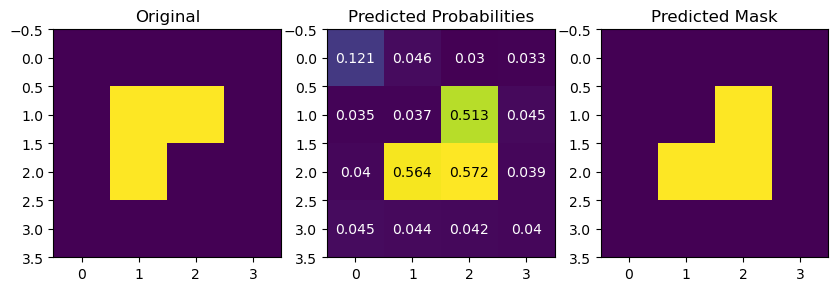

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [22]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

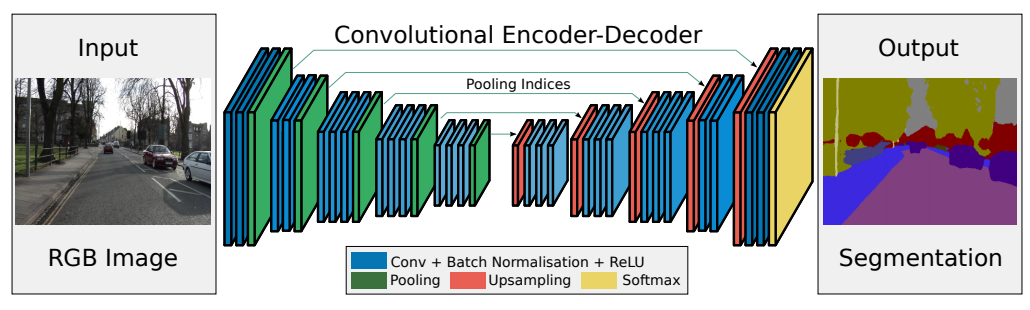

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm
import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [24]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, with_sigmoid=False):
        """
        SegNet архитектура для задач сегментации изображений
        
        Args:
            in_channels (int): Количество входных каналов (обычно 3 для RGB)
            out_channels (int): Количество выходных каналов (обычно 1 для бинарной сегментации)
            with_sigmoid (bool): Применять ли сигмоидную активацию к выходу
        """
        super(SegNet, self).__init__()
        self.with_sigmoid = with_sigmoid
        
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.enc_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Encoder с сохранением индексов для unpooling
        # stage 1
        x1 = self.enc_conv1(x)
        x1_size = x1.size()
        x1_pool, indices1 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)
        
        # stage 2
        x2 = self.enc_conv2(x1_pool)
        x2_size = x2.size()
        x2_pool, indices2 = F.max_pool2d(x2, kernel_size=2, stride=2, return_indices=True)
        
        # stage 3
        x3 = self.enc_conv3(x2_pool)
        x3_size = x3.size()
        x3_pool, indices3 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)
        
        # stage 4
        x4 = self.enc_conv4(x3_pool)
        x4_size = x4.size()
        x4_pool, indices4 = F.max_pool2d(x4, kernel_size=2, stride=2, return_indices=True)
        
        # stage 5
        x5 = self.enc_conv5(x4_pool)
        x5_size = x5.size()
        x5_pool, indices5 = F.max_pool2d(x5, kernel_size=2, stride=2, return_indices=True)
        
        # Decoder с использованием max unpooling
        # stage 5
        x5_unpool = F.max_unpool2d(x5_pool, indices5, kernel_size=2, stride=2, output_size=x5_size)
        y5 = self.dec_conv5(x5_unpool)
        
        # stage 4
        x4_unpool = F.max_unpool2d(y5, indices4, kernel_size=2, stride=2, output_size=x4_size)
        y4 = self.dec_conv4(x4_unpool)
        
        # stage 3
        x3_unpool = F.max_unpool2d(y4, indices3, kernel_size=2, stride=2, output_size=x3_size)
        y3 = self.dec_conv3(x3_unpool)
        
        # stage 2
        x2_unpool = F.max_unpool2d(y3, indices2, kernel_size=2, stride=2, output_size=x2_size)
        y2 = self.dec_conv2(x2_unpool)
        
        # stage 1
        x1_unpool = F.max_unpool2d(y2, indices1, kernel_size=2, stride=2, output_size=x1_size)
        y1 = self.dec_conv1(x1_unpool)
        
        # Применяем сигмоиду, если с активацией
        if self.with_sigmoid:
            out = torch.sigmoid(y1)
        else:
            out = y1
        
        return out

In [26]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

**ВАЖНО!**
Предложенная выше функция bce_loss является реализацией бинарной кросс-энтропии в численно стабильной форме. Изменим sum на mean для сопоставимости с nn.BCELoss. И переопределим.

In [25]:
def bce_loss_stable(y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
    max_term = torch.clamp(y_pred, min=0)
    log_exp_term = torch.log1p(torch.exp(-torch.abs(y_pred)))  # log(1 + exp(-|y_pred|))
    loss = max_term - y_pred * y_real + log_exp_term
    return loss.mean()

In [26]:
# Функция для вычисления IoU (Intersection over Union)
def iou_score(outputs, targets, threshold=0.5):
    smooth = 1e-6
    # Применяем сигмоиду, если outputs - логиты
    if not outputs.max() <= 1:
        outputs = torch.sigmoid(outputs)
    
    # Бинаризация выходов по порогу
    outputs = (outputs > threshold).float()
    
    # Flatten
    outputs = outputs.view(-1)
    targets = targets.view(-1)
    
    # Вычисление IoU
    intersection = (outputs * targets).sum()
    union = outputs.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()

In [27]:
# Функция для обучения модели
def train(w_name, model, train_dataloader, valid_dataloader, num_epochs, device, loss_fn, optimizer):
    # Инициализация списков для хранения времени и потерь
    times = []
    losses = []
    
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        
        # Обучение на тренировочном наборе
        for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = model(images)
            
            # Вычисление функции потерь
            loss = loss_fn(outputs, masks)
            
            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Вычисление среднего значения потерь для эпохи
        epoch_loss = running_loss / len(train_dataloader)
        losses.append(epoch_loss)
        
        # Вычисление времени выполнения эпохи
        epoch_time = time.time() - start_time
        times.append(epoch_time)
        
        # Валидация
        valid_iou = test(model, valid_dataloader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Loss: {epoch_loss:.4f}, "
              f"IoU: {valid_iou:.4f}, "
              f"Time: {epoch_time:.2f}s")
        
        # Сохранение лучшей модели
        if valid_iou > best_iou:
            best_iou = valid_iou
            torch.save(model.state_dict(), f"./weights/{w_name}")
            print(f"Saved best model with IoU: {best_iou:.4f}")
    
    return times, losses

In [28]:
def test(model, dataloader, device):
    model.eval()
    iou_scores = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Прямой проход
            outputs = model(images)
            
            # Вычисление IoU
            batch_iou = iou_score(outputs, masks)
            iou_scores.append(batch_iou)
    
    # Вычисление среднего IoU
    mean_iou = np.mean(iou_scores)
    
    return mean_iou

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [39]:
result_dict = {}
max_epochs = 30

In [32]:
optim = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
seg_bce_name = "best_segnet_bce_model.pth"
seg_bce_times, seg_bce_losses = train(seg_bce_name, segnet_model, train_dataloader, valid_dataloader, max_epochs, device, bce_loss_stable, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.6635, IoU: 0.0000, Time: 48.47s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.5522, IoU: 0.0000, Time: 43.43s
Saved best model with IoU: 0.0000


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.4429, IoU: 0.0000, Time: 44.21s


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.3410, IoU: 0.2241, Time: 43.04s
Saved best model with IoU: 0.2241


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.3041, IoU: 0.4351, Time: 53.53s
Saved best model with IoU: 0.4351


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.3089, IoU: 0.5638, Time: 48.37s
Saved best model with IoU: 0.5638


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.2438, IoU: 0.6599, Time: 45.73s
Saved best model with IoU: 0.6599


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.2126, IoU: 0.7273, Time: 46.12s
Saved best model with IoU: 0.7273


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.1981, IoU: 0.7311, Time: 45.92s
Saved best model with IoU: 0.7311


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.2071, IoU: 0.7393, Time: 47.68s
Saved best model with IoU: 0.7393


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.1785, IoU: 0.7432, Time: 46.75s
Saved best model with IoU: 0.7432


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.2312, IoU: 0.7613, Time: 44.73s
Saved best model with IoU: 0.7613


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.1835, IoU: 0.7436, Time: 45.83s


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.1714, IoU: 0.7350, Time: 47.23s


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.1901, IoU: 0.7068, Time: 46.80s


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.1833, IoU: 0.7123, Time: 44.94s


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.1787, IoU: 0.7488, Time: 45.98s


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.1755, IoU: 0.7475, Time: 45.59s


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.1725, IoU: 0.7772, Time: 49.38s
Saved best model with IoU: 0.7772


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.1513, IoU: 0.7506, Time: 45.69s


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.1585, IoU: 0.7695, Time: 45.31s


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.2109, IoU: 0.7699, Time: 44.88s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.1999, IoU: 0.7592, Time: 45.18s


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.1823, IoU: 0.7553, Time: 45.64s


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.1713, IoU: 0.7750, Time: 46.18s


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [32]:
def print_result(model, model_name, test_data, device, test_iou):
    X_val, Y_val = next(iter(test_data))
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    model.eval()  # testing mode
    Y_hat = model(X_val).detach().cpu().numpy() # detach and put into cpu
    for k in range(6):
        plt.subplot(2, 6, k+1)
        #plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.imshow(np.transpose(X_val[k].cpu().numpy(), (1, 2, 0)), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.suptitle(f"Model: {model_name[:-10]}, IoU: {test_iou:.4f}")
    plt.show()
    print(f"{test_iou:.4f}")

In [35]:
# Загрузка лучшей модели и тестирование
segnet_model.load_state_dict(torch.load(f"./weights/{seg_bce_name}"))

C:\Temp\ipykernel_1332\1623188408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segnet_model.load_state_dict(torch.load(f"./weights/{seg_bce_name}"))


<All keys matched successfully>

In [36]:
test_iou = test(segnet_model, test_dataloader, device)

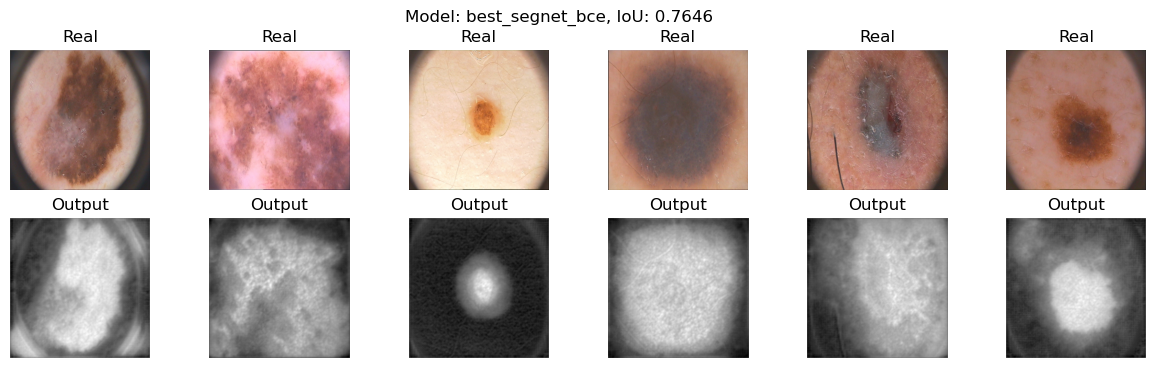

0.7646


In [60]:
print_result(segnet_model, seg_bce_name, test_dataloader, device, test_iou)

In [39]:
result_dict['segnet_bce'] = (test_iou, seg_bce_times, seg_bce_losses)

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_loss.

In [45]:
def dice_loss(y_pred: torch.Tensor, y_real: torch.Tensor, smooth=1e-6) -> torch.Tensor:
    # Если в модели больше нет сигмоиды, применяем её здесь
    y_pred = torch.sigmoid(y_pred)
    
    # Flatten предсказания и целевые значения
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    
    # Вычисляем пересечение и объединение
    intersection = (y_pred * y_real).sum()
    union = y_pred.sum() + y_real.sum()
    
    # Вычисляем Dice коэффициент
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    # Преобразуем в loss (1 - dice)
    return 1.0 - dice

Проверка на корректность:

In [46]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [47]:
assert torch.isclose(dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']), dice_loss(dummpy_sample['logits'], dummpy_sample['labels']))

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [48]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma=2 , alpha=0.25):
    """
    Реализация Focal Loss для бинарной сегментации.
    
    Args:
        y_pred: Предсказания модели (логиты)
        y_real: Целевые значения (0 или 1)
        gamma: Параметр фокусировки (больше значение - больше фокус на сложных примерах)
        alpha: Весовой коэффициент для балансировки классов
        
    Returns:
        torch.Tensor: Значение функции потерь
    """
    # Применяем сигмоиду к логитам
    y_pred = torch.sigmoid(y_pred)
    
    # Вычисляем бинарную кросс-энтропию поэлементно
    bce = -y_real * torch.log(y_pred + eps) - (1 - y_real) * torch.log(1 - y_pred + eps)
    
    # Применяем модулирующий фактор для фокусировки
    pt = y_real * y_pred + (1 - y_real) * (1 - y_pred)
    focal_weight = (1 - pt) ** gamma
    
    # Применяем alpha-балансировку
    alpha_weight = y_real * alpha + (1 - y_real) * (1 - alpha)
    
    # Итоговая Focal Loss
    loss = alpha_weight * focal_weight * bce
    
    return loss.mean()

Проверка корректности функции:

In [49]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [50]:
assert torch.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'), focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0, alpha=0.2639), atol=1e-2)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [36]:
def ssl_loss(y_pred: torch.Tensor, y_real: torch.Tensor, window_size=11, size_average=True, sigma=1.5, alpha=0.84, beta=0.16, gamma=1.0):
    """
    Correlation Maximized Structural Similarity Loss (CM-SSIM Loss) для задач сегментации
    
    Args:
        y_pred (torch.Tensor): Предсказания модели (логиты)
        y_real (torch.Tensor): Целевые маски
        window_size (int): Размер окна для вычисления SSIM
        size_average (bool): Усреднять ли результат по батчу
        sigma (float): Параметр для гауссовского ядра
        alpha (float): Вес для компонента структурного сходства
        beta (float): Вес для компонента корреляции
        gamma (float): Параметр для регулирования чувствительности к различиям
    
    Returns:
        torch.Tensor: Значение функции потерь
    """
    # Применяем сигмоиду к предсказаниям, если они в формате логитов
    y_pred = torch.sigmoid(y_pred)
    
    # Создаем гауссовское ядро для оценки локальных статистик
    def create_gaussian_kernel(window_size, sigma):
        coords = torch.arange(window_size, device=y_pred.device).float() - window_size // 2
        kernel = torch.exp(-(coords**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        return kernel.unsqueeze(0).unsqueeze(0)
    
    # Создаем гауссовское ядро
    window_1D = create_gaussian_kernel(window_size, sigma)
    window_2D = window_1D.matmul(window_1D.transpose(2, 3))
    
    # Расширяем ядро для соответствия размерности входных данных
    window = window_2D.expand(y_pred.size(1), 1, window_size, window_size)
    
    # Вычисляем локальные средние и дисперсии с помощью свертки
    mu1 = F.conv2d(y_pred, window, padding=window_size // 2, groups=y_pred.size(1))
    mu2 = F.conv2d(y_real, window, padding=window_size // 2, groups=y_real.size(1))
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(y_pred * y_pred, window, padding=window_size // 2, groups=y_pred.size(1)) - mu1_sq
    sigma2_sq = F.conv2d(y_real * y_real, window, padding=window_size // 2, groups=y_real.size(1)) - mu2_sq
    sigma12 = F.conv2d(y_pred * y_real, window, padding=window_size // 2, groups=y_pred.size(1)) - mu1_mu2
    
    # Константы для стабильности
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    # Вычисляем компоненты SSIM
    ssim_numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    ssim_denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_map = ssim_numerator / ssim_denominator
    
    # Вычисляем компонент корреляции Пирсона
    var_x = sigma1_sq + 1e-8
    var_y = sigma2_sq + 1e-8
    covar_xy = sigma12
    
    corr_map = covar_xy / torch.sqrt(var_x * var_y + 1e-8)
    
    # Комбинируем компоненты структурного сходства и корреляции
    cm_ssim_map = (alpha * ssim_map) + (beta * corr_map ** gamma)
    
    # Вычисляем финальную функцию потерь
    loss = 1.0 - cm_ssim_map
    
    if size_average:
        return loss.mean()
    else:
        return loss.mean(1).mean(1).mean(1)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



#### SegNet: Dice Loss

In [52]:
segnet_dice_model = SegNet().to(device)

In [53]:
optim = torch.optim.Adam(segnet_dice_model.parameters(), lr=1e-3)
seg_dice_name = "best_segnet_dice_model.pth"
seg_dice_times, seg_dice_losses = train(seg_dice_name, segnet_dice_model, train_dataloader, valid_dataloader, max_epochs, device, dice_loss, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.5492, IoU: 0.0000, Time: 44.64s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.4233, IoU: 0.0000, Time: 42.34s


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.3283, IoU: 0.3419, Time: 43.52s
Saved best model with IoU: 0.3419


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.2775, IoU: 0.3111, Time: 47.21s


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.2250, IoU: 0.4485, Time: 44.28s
Saved best model with IoU: 0.4485


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.2096, IoU: 0.4812, Time: 46.75s
Saved best model with IoU: 0.4812


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.1653, IoU: 0.5684, Time: 48.59s
Saved best model with IoU: 0.5684


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.1465, IoU: 0.6322, Time: 46.18s
Saved best model with IoU: 0.6322


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.1401, IoU: 0.6725, Time: 43.25s
Saved best model with IoU: 0.6725


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.1375, IoU: 0.7105, Time: 45.03s
Saved best model with IoU: 0.7105


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.1279, IoU: 0.7332, Time: 41.16s
Saved best model with IoU: 0.7332


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.1173, IoU: 0.7457, Time: 41.34s
Saved best model with IoU: 0.7457


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.1248, IoU: 0.7569, Time: 42.43s
Saved best model with IoU: 0.7569


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.1235, IoU: 0.7621, Time: 41.80s
Saved best model with IoU: 0.7621


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.1100, IoU: 0.7615, Time: 41.51s


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.1186, IoU: 0.7742, Time: 42.70s
Saved best model with IoU: 0.7742


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.1309, IoU: 0.7244, Time: 45.97s


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.1078, IoU: 0.7343, Time: 43.15s


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.1121, IoU: 0.7650, Time: 45.61s


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.1012, IoU: 0.7646, Time: 43.05s


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.1150, IoU: 0.7540, Time: 43.31s


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.1068, IoU: 0.7377, Time: 41.51s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.1191, IoU: 0.7448, Time: 42.74s


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.1113, IoU: 0.7509, Time: 40.67s


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.1092, IoU: 0.7385, Time: 42.86s


In [54]:
segnet_dice_model.load_state_dict(torch.load(f"./weights/{seg_dice_name}"))

C:\Temp\ipykernel_1332\203620534.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segnet_dice_model.load_state_dict(torch.load(f"./weights/{seg_dice_name}"))


<All keys matched successfully>

In [55]:
seg_dice_test_iou = test(segnet_dice_model, test_dataloader, device)

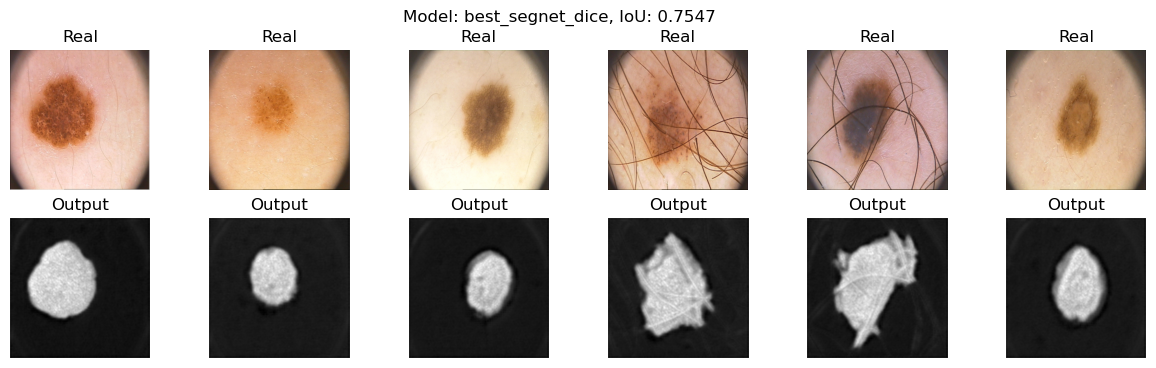

0.7547


In [61]:
print_result(segnet_dice_model, seg_dice_name, test_dataloader, device, seg_dice_test_iou)

In [62]:
result_dict['segnet_dice'] = (seg_dice_test_iou, seg_dice_times, seg_dice_losses)

#### SegNet: Focal Loss

In [63]:
segnet_focal_model = SegNet().to(device)

In [64]:
optim = torch.optim.Adam(segnet_focal_model.parameters(), lr=1e-3)
seg_focal_name = "best_segnet_focal_model.pth"
seg_focal_times, seg_focal_losses = train(seg_focal_name, segnet_focal_model, train_dataloader, valid_dataloader, max_epochs, device, focal_loss, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.0965, IoU: 0.0000, Time: 37.41s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.0561, IoU: 0.0000, Time: 33.41s
Saved best model with IoU: 0.0000


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.0407, IoU: 0.0679, Time: 33.56s
Saved best model with IoU: 0.0679


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.0369, IoU: 0.0050, Time: 33.96s


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.0324, IoU: 0.2496, Time: 33.60s
Saved best model with IoU: 0.2496


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.0296, IoU: 0.2276, Time: 34.14s


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.0293, IoU: 0.3241, Time: 33.59s
Saved best model with IoU: 0.3241


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.0288, IoU: 0.3759, Time: 34.80s
Saved best model with IoU: 0.3759


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.0280, IoU: 0.6785, Time: 33.17s
Saved best model with IoU: 0.6785


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.0274, IoU: 0.5911, Time: 34.19s


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.0253, IoU: 0.6731, Time: 34.20s


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.0269, IoU: 0.6295, Time: 36.00s


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.0235, IoU: 0.7228, Time: 35.00s
Saved best model with IoU: 0.7228


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.0236, IoU: 0.6815, Time: 34.47s


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.0247, IoU: 0.4416, Time: 35.01s


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.0260, IoU: 0.7102, Time: 34.02s


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.0255, IoU: 0.7375, Time: 33.93s
Saved best model with IoU: 0.7375


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.0235, IoU: 0.7355, Time: 33.74s


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.0239, IoU: 0.7289, Time: 34.51s


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.0221, IoU: 0.7270, Time: 33.78s


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.0211, IoU: 0.7014, Time: 36.98s


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.0211, IoU: 0.7295, Time: 34.28s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.0224, IoU: 0.7150, Time: 33.89s


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.0219, IoU: 0.7607, Time: 33.89s
Saved best model with IoU: 0.7607


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.0206, IoU: 0.7397, Time: 35.52s


In [65]:
segnet_focal_model.load_state_dict(torch.load(f"./weights/{seg_focal_name}"))

C:\Temp\ipykernel_1332\3849167928.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segnet_focal_model.load_state_dict(torch.load(f"./weights/{seg_focal_name}"))


<All keys matched successfully>

In [66]:
seg_focal_test_iou = test(segnet_focal_model, test_dataloader, device)

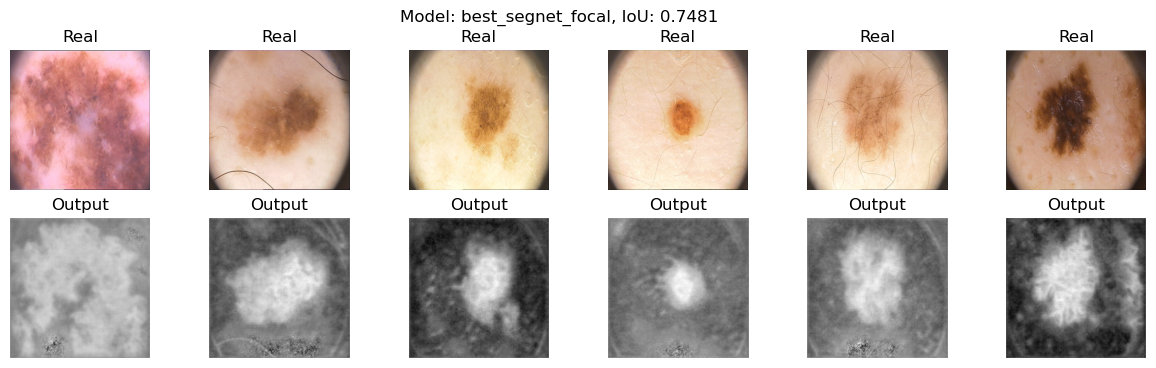

0.7481


In [67]:
print_result(segnet_focal_model, seg_focal_name, test_dataloader, device, seg_focal_test_iou)

In [68]:
result_dict['segnet_focal'] = (seg_focal_test_iou, seg_focal_times, seg_focal_losses)

#### SegNet: Correlation Maximized Structural Similarity Loss

In [37]:
segnet_ssl_model = SegNet().to(device)

In [38]:
optim = torch.optim.Adam(segnet_ssl_model.parameters(), lr=1e-3)
seg_ssl_name = "best_segnet_ssl_model.pth"
seg_ssl_times, seg_ssl_losses = train(seg_ssl_name, segnet_ssl_model, train_dataloader, valid_dataloader, max_epochs, device, ssl_loss, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 100.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.46 GiB is allocated by PyTorch, and 179.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [71]:
segnet_ssl_model.load_state_dict(torch.load(f"./weights/{seg_ssl_name}"))

C:\Temp\ipykernel_1332\1702422918.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segnet_ssl_model.load_state_dict(torch.load(f"./weights/{seg_ssl_name}"))


<All keys matched successfully>

In [72]:
seg_ssl_test_iou = test(segnet_ssl_model, test_dataloader, device)

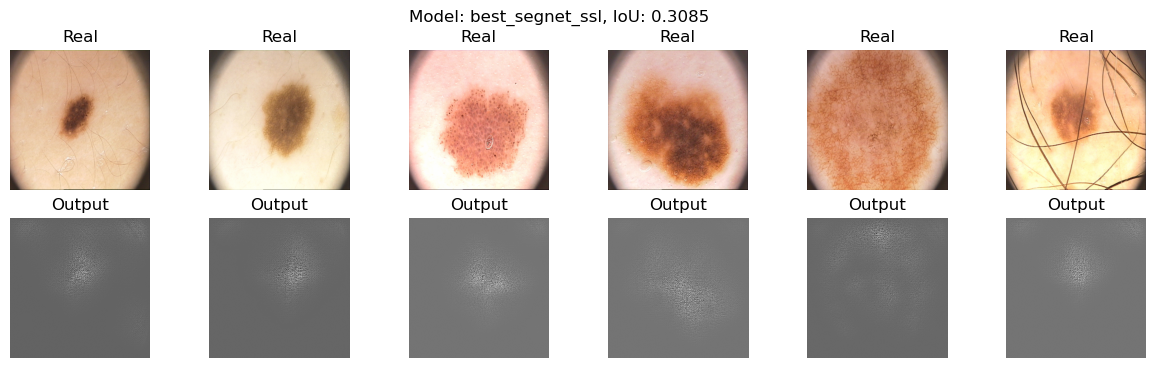

0.3085


In [73]:
print_result(segnet_ssl_model, seg_ssl_name, test_dataloader, device, seg_ssl_test_iou)

In [74]:
result_dict['segnet_ssl'] = (seg_ssl_test_iou, seg_ssl_times, seg_ssl_losses)

Сохраним данные в словарь

In [78]:
import pickle
with open('train_log.pkl', 'wb') as f: 
    pickle.dump(result_dict, f) 

#### Ответы на вопросы

In [92]:
import pandas as pd

def print_losses(rd):
    all_losses = []
    labels = []

    for k, v in rd.items():
        labels.append(k)
        all_losses.append(v[2])

    plt.figure(figsize=(10, 8))

    # Plot each set of losses
    for losses, label in zip(all_losses, labels):
        # new_loses = []
        # for loss in losses:

          # if isinstance(loss, torch.Tensor):
          #    loss = loss.cpu().detach().numpy()
          #    new_loses.append(loss)

        plt.plot(range(1, max_epochs + 1), losses, label=label)

    plt.title('Сравнение Loss моделей в зависимости от эпох')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(title='Model', loc='upper right')
    plt.grid()
    plt.show()

def create_table(rd):
    model_names = [k for k in rd.keys()]

    scores = [v[0] for v in rd.values()]
    tr_times = [sum(v[1]) for v in rd.values()]

    df = pd.DataFrame({'score': scores, 'training_time': tr_times}, index=model_names)
    df.sort_values(by='score', ascending=False, inplace=True)
    return df

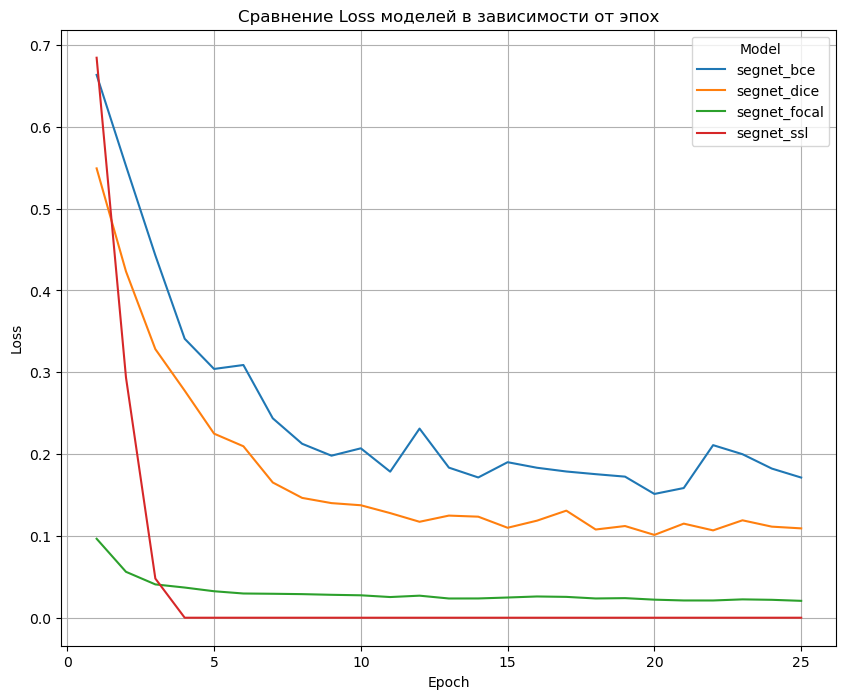

In [88]:
print_losses(result_dict)

In [93]:
res_df = create_table(result_dict)
res_df

score  training_time
segnet_bce    0.764647    1156.632559
segnet_dice   0.754666    1091.623352
segnet_focal  0.748098     861.040257
segnet_ssl    0.308451    1015.719196

* Быстрее всего модель сошлась при Focal Loss
* SegNet с BCE Loss выдает лучшую метрику: **0.76**

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

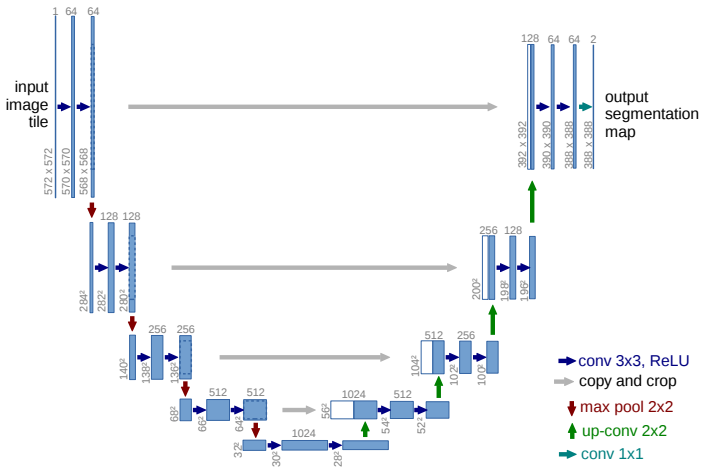

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [94]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        #print(e0.size())
        e1 = self.pool1(self.enc_conv1(e0))
        #print(e1.size())
        e2 = self.pool2(self.enc_conv2(e1))
        #print(e2.size())
        e3 = self.pool3(self.enc_conv3(e2))
        #print(e3.size())

        # bottleneck
        b = self.bottleneck_conv(e3)
        #print(b.size())

        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.concat([e3, b], 1)))
        #print(d0.size())
        d1 = self.dec_conv1(self.upsample1(torch.concat([e2, d0], 1)))
        #print(d1.size())
        d2 = self.dec_conv2(self.upsample2(torch.concat([e1, d1], 1)))
        #print(d2.size())
        d3 = self.dec_conv3(self.upsample3(torch.concat([e0, d2], 1)))
        #print(d3.size())  # no activation
        return d3


## Обучите UNet

#### UNet: BCE Loss

In [95]:
unet_bce_model = UNet().to(device)

In [96]:
optim = torch.optim.Adam(unet_bce_model.parameters(), lr=1e-3)
unet_bce_name = "best_unet_bce_model.pth"
unet_bce_times, unet_bce_losses = train(unet_bce_name, unet_bce_model, train_dataloader, valid_dataloader, max_epochs, device, bce_loss_stable, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.5947, IoU: 0.0000, Time: 62.33s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.4484, IoU: 0.0000, Time: 50.32s


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.4235, IoU: 0.0110, Time: 55.77s
Saved best model with IoU: 0.0110


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.4115, IoU: 0.2011, Time: 50.42s
Saved best model with IoU: 0.2011


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.4009, IoU: 0.2176, Time: 50.68s
Saved best model with IoU: 0.2176


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.3875, IoU: 0.1887, Time: 52.23s


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.3837, IoU: 0.3294, Time: 55.18s
Saved best model with IoU: 0.3294


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.3997, IoU: 0.6024, Time: 54.96s
Saved best model with IoU: 0.6024


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.3865, IoU: 0.4202, Time: 57.79s


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3706, IoU: 0.5384, Time: 57.69s


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.3819, IoU: 0.5117, Time: 54.92s


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.3627, IoU: 0.6816, Time: 59.49s
Saved best model with IoU: 0.6816


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.3590, IoU: 0.7398, Time: 56.55s
Saved best model with IoU: 0.7398


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.3568, IoU: 0.7089, Time: 50.09s


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3800, IoU: 0.7546, Time: 58.51s
Saved best model with IoU: 0.7546


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.3617, IoU: 0.8215, Time: 68.37s
Saved best model with IoU: 0.8215


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.3546, IoU: 0.8292, Time: 56.60s
Saved best model with IoU: 0.8292


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.3622, IoU: 0.7334, Time: 62.74s


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.3502, IoU: 0.8281, Time: 76.76s


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3523, IoU: 0.8498, Time: 86.76s
Saved best model with IoU: 0.8498


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.3429, IoU: 0.8334, Time: 126.65s


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.3435, IoU: 0.8295, Time: 76.66s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.3421, IoU: 0.8293, Time: 92.67s


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.3446, IoU: 0.8485, Time: 102.74s


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.3417, IoU: 0.8429, Time: 86.68s


In [97]:
unet_bce_model.load_state_dict(torch.load(f"./weights/{unet_bce_name}"))

C:\Temp\ipykernel_1332\3618857220.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_bce_model.load_state_dict(torch.load(f"./weights/{unet_bce_name}"))


<All keys matched successfully>

In [98]:
unet_bce_test_iou = test(unet_bce_model, test_dataloader, device)

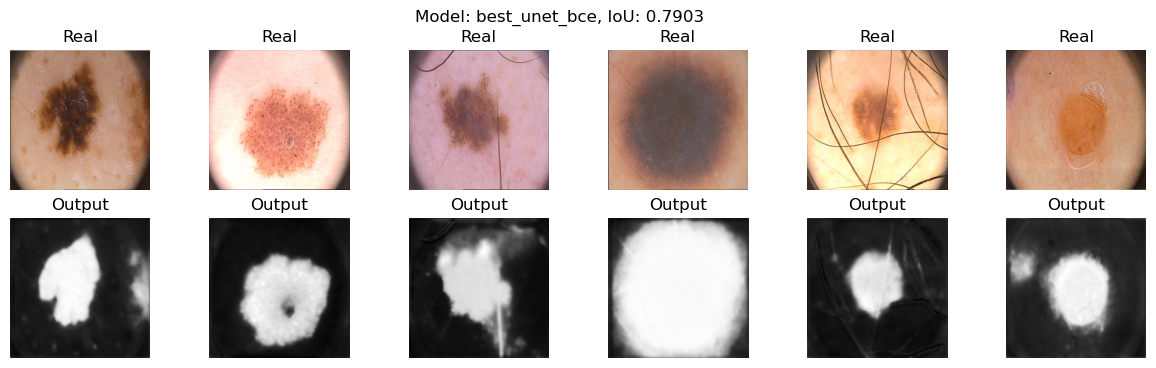

0.7903


In [99]:
print_result(unet_bce_model, unet_bce_name, test_dataloader, device, unet_bce_test_iou)

In [100]:
result_dict['unet_bce'] = (unet_bce_test_iou, unet_bce_times, unet_bce_losses)

#### UNet: Dice Loss

In [101]:
unet_dice_model = UNet().to(device)

In [102]:
optim = torch.optim.Adam(unet_dice_model.parameters(), lr=1e-3)
unet_dice_name = "best_unet_dice_model.pth"
unet_dice_times, unet_dice_losses = train(unet_dice_name, unet_dice_model, train_dataloader, valid_dataloader, max_epochs, device, dice_loss, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.4543, IoU: 0.0000, Time: 61.94s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.4093, IoU: 0.0000, Time: 41.29s


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.3939, IoU: 0.0000, Time: 76.28s
Saved best model with IoU: 0.0000


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.3923, IoU: 0.0694, Time: 70.87s
Saved best model with IoU: 0.0694


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.3835, IoU: 0.1644, Time: 69.12s
Saved best model with IoU: 0.1644


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.3782, IoU: 0.2803, Time: 65.53s
Saved best model with IoU: 0.2803


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.3784, IoU: 0.4802, Time: 47.10s
Saved best model with IoU: 0.4802


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.3719, IoU: 0.7238, Time: 44.90s
Saved best model with IoU: 0.7238


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.3698, IoU: 0.5937, Time: 45.88s


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3658, IoU: 0.7527, Time: 46.40s
Saved best model with IoU: 0.7527


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.3687, IoU: 0.6209, Time: 69.22s


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.3695, IoU: 0.7687, Time: 48.05s
Saved best model with IoU: 0.7687


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.3678, IoU: 0.7902, Time: 44.32s
Saved best model with IoU: 0.7902


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.3644, IoU: 0.7593, Time: 44.98s


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3624, IoU: 0.7671, Time: 41.23s


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.3603, IoU: 0.7758, Time: 41.50s


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.3586, IoU: 0.7741, Time: 42.75s


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.3542, IoU: 0.7949, Time: 39.24s
Saved best model with IoU: 0.7949


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.3535, IoU: 0.8131, Time: 39.74s
Saved best model with IoU: 0.8131


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3578, IoU: 0.8281, Time: 44.67s
Saved best model with IoU: 0.8281


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.3483, IoU: 0.8011, Time: 44.25s


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.3496, IoU: 0.7846, Time: 40.39s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.3553, IoU: 0.7784, Time: 62.93s


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.3515, IoU: 0.7741, Time: 41.80s


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.3437, IoU: 0.7387, Time: 38.99s


In [103]:
unet_dice_model.load_state_dict(torch.load(f"./weights/{unet_dice_name}"))

C:\Temp\ipykernel_1332\2579302703.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_dice_model.load_state_dict(torch.load(f"./weights/{unet_dice_name}"))


<All keys matched successfully>

In [104]:
unet_dice_test_iou = test(unet_dice_model, test_dataloader, device)

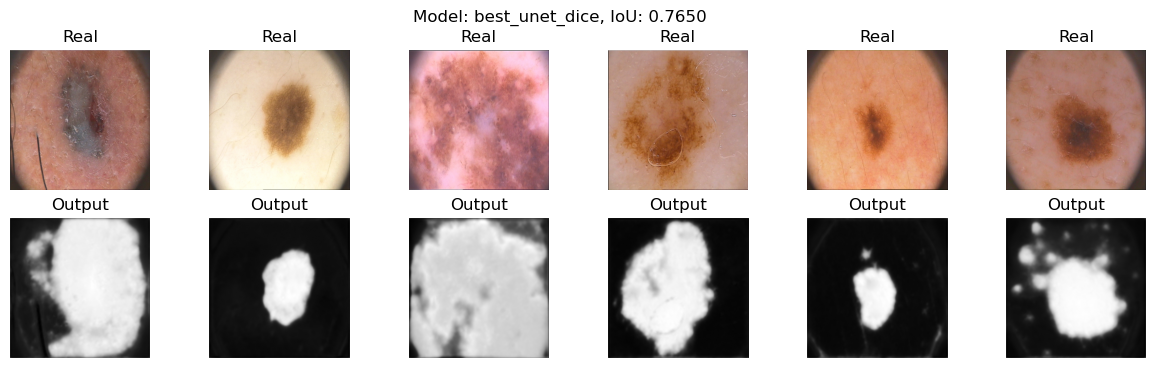

0.7650


In [105]:
print_result(unet_dice_model, unet_dice_name, test_dataloader, device, unet_dice_test_iou)

In [106]:
result_dict['unet_dice'] = (unet_dice_test_iou, unet_dice_times, unet_dice_losses)

#### UNet: Focal Loss

In [109]:
unet_focal_model = UNet().to(device)

In [110]:
optim = torch.optim.Adam(unet_focal_model.parameters(), lr=1e-3)
unet_focal_name = "best_unet_focal_model.pth"
unet_focal_times, unet_focal_losses = train(unet_focal_name, unet_focal_model, train_dataloader, valid_dataloader, max_epochs, device, focal_loss, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.0880, IoU: 0.0000, Time: 57.22s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.0479, IoU: 0.0000, Time: 54.89s
Saved best model with IoU: 0.0000


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.0418, IoU: 0.0204, Time: 54.80s
Saved best model with IoU: 0.0204


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.0422, IoU: 0.0075, Time: 54.92s


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.0406, IoU: 0.0000, Time: 58.51s


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.0380, IoU: 0.0000, Time: 54.94s


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.0371, IoU: 0.0238, Time: 54.87s
Saved best model with IoU: 0.0238


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.0354, IoU: 0.1481, Time: 54.90s
Saved best model with IoU: 0.1481


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.0342, IoU: 0.3153, Time: 55.09s
Saved best model with IoU: 0.3153


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.0327, IoU: 0.5025, Time: 54.93s
Saved best model with IoU: 0.5025


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.0329, IoU: 0.6708, Time: 54.80s
Saved best model with IoU: 0.6708


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.0319, IoU: 0.7617, Time: 54.99s
Saved best model with IoU: 0.7617


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.0317, IoU: 0.7935, Time: 54.94s
Saved best model with IoU: 0.7935


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.0350, IoU: 0.4355, Time: 56.30s


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.0390, IoU: 0.6044, Time: 54.93s


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.0374, IoU: 0.6249, Time: 54.88s


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.0348, IoU: 0.6758, Time: 54.91s


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.0331, IoU: 0.7502, Time: 54.81s


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.0331, IoU: 0.7674, Time: 54.88s


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.0316, IoU: 0.7936, Time: 54.97s
Saved best model with IoU: 0.7936


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.0302, IoU: 0.8005, Time: 54.81s
Saved best model with IoU: 0.8005


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.0294, IoU: 0.7895, Time: 54.81s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.0302, IoU: 0.8185, Time: 54.87s
Saved best model with IoU: 0.8185


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.0300, IoU: 0.7916, Time: 54.82s


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.0279, IoU: 0.8177, Time: 54.85s


In [111]:
unet_focal_model.load_state_dict(torch.load(f"./weights/{unet_focal_name}"))

C:\Temp\ipykernel_1332\1417241385.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_focal_model.load_state_dict(torch.load(f"./weights/{unet_focal_name}"))


<All keys matched successfully>

In [112]:
unet_focal_test_iou = test(unet_focal_model, test_dataloader, device)

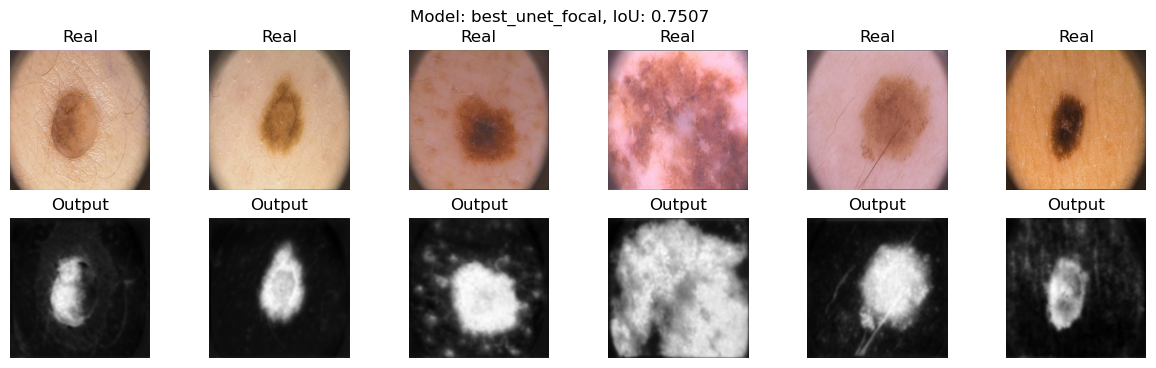

0.7507


In [113]:
print_result(unet_focal_model, unet_focal_name, test_dataloader, device, unet_focal_test_iou)

In [114]:
result_dict['unet_focal'] = (unet_focal_test_iou, unet_focal_times, unet_focal_losses)

#### UNet: Correlation Maximized Structural Similarity Loss

In [115]:
unet_ssl_model = UNet().to(device)

In [116]:
optim = torch.optim.Adam(unet_ssl_model.parameters(), lr=1e-3)
unet_ssl_name = "best_unet_ssl_model.pth"
unet_ssl_times, unet_ssl_losses = train(unet_ssl_name, unet_ssl_model, train_dataloader, valid_dataloader, max_epochs, device, ssl_loss, optim)

Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, Loss: 0.4877, IoU: 0.0000, Time: 54.18s
Saved best model with IoU: 0.0000


Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, Loss: 0.0742, IoU: 0.0000, Time: 51.47s


Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, Loss: 0.0000, IoU: 0.0000, Time: 51.36s


Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, Loss: 0.0000, IoU: 0.0000, Time: 51.49s


Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.0000, IoU: 0.0000, Time: 51.43s


Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, Loss: 0.0000, IoU: 0.0000, Time: 51.53s


Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, Loss: 0.0000, IoU: 0.0000, Time: 51.43s


Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, Loss: 0.0000, IoU: 0.0000, Time: 51.55s


Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, Loss: 0.0000, IoU: 0.0000, Time: 51.43s


Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.0000, IoU: 0.0000, Time: 51.37s


Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, Loss: 0.0000, IoU: 0.0000, Time: 51.40s
Saved best model with IoU: 0.0000


Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, Loss: 0.0000, IoU: 0.0000, Time: 51.44s


Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, Loss: 0.0000, IoU: 0.0000, Time: 51.41s


Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, Loss: 0.0000, IoU: 0.0000, Time: 51.34s


Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.0000, IoU: 0.0000, Time: 51.36s


Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, Loss: 0.0000, IoU: 0.0000, Time: 51.42s


Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, Loss: 0.0000, IoU: 0.0000, Time: 51.68s


Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, Loss: 0.0000, IoU: 0.0000, Time: 51.58s


Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, Loss: 0.0000, IoU: 0.0000, Time: 51.62s


Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.0000, IoU: 0.0000, Time: 51.42s


Epoch 21/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, Loss: 0.0000, IoU: 0.0000, Time: 51.43s


Epoch 22/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, Loss: 0.0000, IoU: 0.0000, Time: 51.44s


Epoch 23/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, Loss: 0.0000, IoU: 0.0000, Time: 51.42s


Epoch 24/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, Loss: 0.0000, IoU: 0.0000, Time: 51.39s


Epoch 25/25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.0000, IoU: 0.0000, Time: 51.79s


In [117]:
unet_ssl_model.load_state_dict(torch.load(f"./weights/{unet_ssl_name}"))

C:\Temp\ipykernel_1332\495203230.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_ssl_model.load_state_dict(torch.load(f"./weights/{unet_ssl_name}"))


<All keys matched successfully>

In [118]:
unet_ssl_test_iou = test(unet_ssl_model, test_dataloader, device)

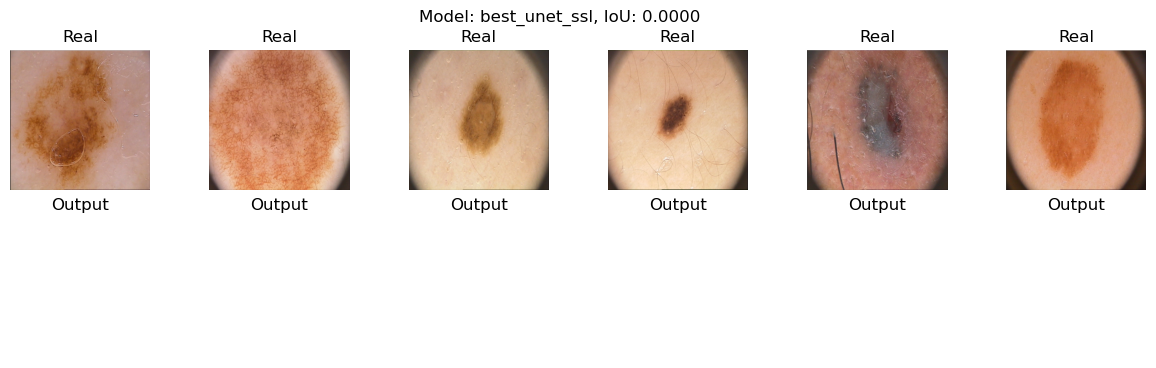

0.0000


In [119]:
print_result(unet_ssl_model, unet_ssl_name, test_dataloader, device, unet_ssl_test_iou)

In [120]:
result_dict['unet_ssl'] = (unet_ssl_test_iou, unet_ssl_times, unet_ssl_losses)

Сохраним данные:

In [121]:
import pickle
with open('train_log.pkl', 'wb') as f: 
    pickle.dump(result_dict, f) 

Загрузим данные:

In [ ]:
import pickle
with open('train_log.pkl', 'rb') as f:
    result_dict = pickle.load(f)

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



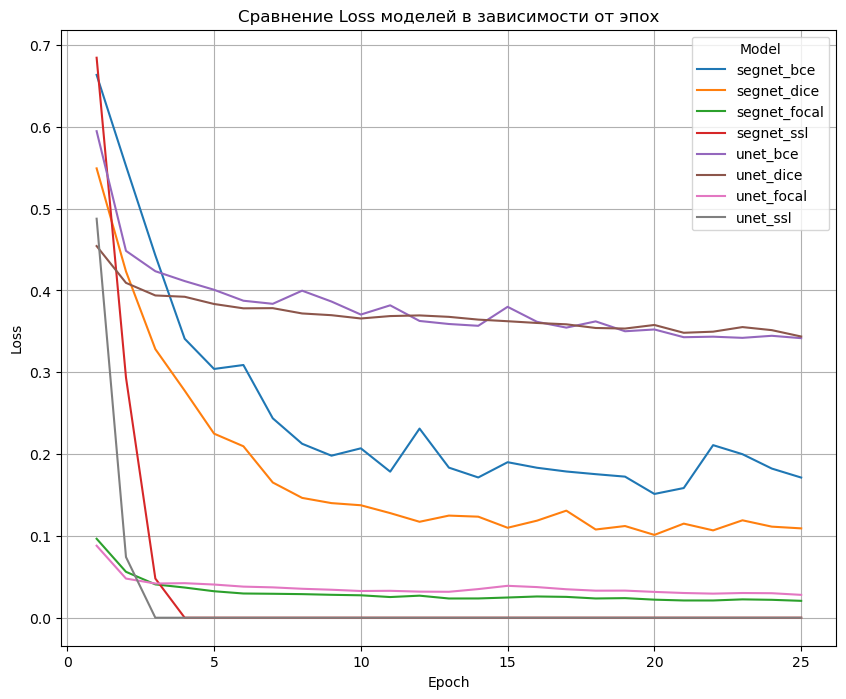

In [122]:
print_losses(result_dict)

In [123]:
res2_df = create_table(result_dict)
res2_df

score  training_time
unet_bce      7.903319e-01    1663.569150
unet_dice     7.649513e-01    1253.369853
segnet_bce    7.646466e-01    1156.632559
segnet_dice   7.546657e-01    1091.623352
unet_focal    7.506574e-01    1379.648047
segnet_focal  7.480980e-01     861.040257
segnet_ssl    3.084513e-01    1015.719196
unet_ssl      2.205030e-12    1289.391777

#### Вывод

Для SegNet получилось, что при BCE модель сходится быстрее всего. Далее идут Dice и SSL. Наиболее высокое качество **SegNet - Dice, 0.62**.

Самая лучшая модель по значениям метрики: **UNet - BCE, 0.73**.
Если суммировать по всем лоссам, то лучше себя показала модель UNet, но обучается она в 10 раз медленнее по сравнению с SegNet, что логично ведь параметров в UNet в разы больше чем в SegNet. Отсюда логично, что SegNet обучится быстрее. Но в то же время, для всех лоссов при использовании модели SegNet значение лосса падает значительно медленнее, чем у UNet.

---